Building an LDA Topic Model for Grouping Songs by Their Lyrics

In [70]:
# Import Libraries

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud

In [71]:
# Load data into list
songs_df = pd.read_csv("spotify_millsongdata.csv", nrows=5000)
data = list(songs_df["text"])

# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 5000

First song: Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?  
  
And when we go for a walk in the park  
And she holds me and squeezes my hand  
We'll go on walking for hours and talking  
About all the things that we plan  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?




In [72]:
# Clean text
clean_data = [i.replace('\n','').replace('\r','') for i in data]

In [73]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [74]:
%%time

# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=8, batch_size=1000)))

# Print example
print(tokenized_data[0])

['look', 'face', 'wonderful', 'face', 'mean', 'special', 'look', 'way', 'smile', 'see', 'lucky', 'fellow', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave', 'walk', 'park', 'hold', 'squeeze', 'hand', 'walk', 'hour', 'talk', 'thing', 'plan', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave']
CPU times: total: 49.7 s
Wall time: 4min 28s


In [75]:
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 12443

Size of vocabulary after filtering: 3312

Example mappings: [('look', 12), ('face', 2), ('wonderful', 26), ('face', 2), ('mean', 15), ('special', 20), ('look', 12), ('way', 25), ('smile', 19), ('see', 18)]


In [76]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]


In [77]:
%%time

# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=1, alpha='auto', eta='auto', id2word=dct, random_state=0)




CPU times: total: 1.61 s
Wall time: 2.98 s


In [78]:
# Print generated topics
lda_model.print_topics()

[(0,
  '0.028*"dream" + 0.023*"time" + 0.017*"believe" + 0.016*"get" + 0.012*"wish" + 0.011*"day" + 0.011*"sing" + 0.010*"let" + 0.010*"shout" + 0.009*"good"'),
 (1,
  '0.029*"heart" + 0.021*"man" + 0.020*"dance" + 0.019*"wait" + 0.017*"live" + 0.016*"help" + 0.012*"take" + 0.010*"die" + 0.009*"ride" + 0.008*"night"'),
 (2,
  '0.024*"come" + 0.017*"get" + 0.015*"love" + 0.012*"try" + 0.011*"think" + 0.010*"tell" + 0.010*"let" + 0.010*"need" + 0.010*"way" + 0.010*"go"'),
 (3,
  '0.025*"come" + 0.024*"day" + 0.016*"blue" + 0.016*"little" + 0.014*"boy" + 0.013*"girl" + 0.009*"good" + 0.009*"go" + 0.009*"life" + 0.008*"people"'),
 (4,
  '0.052*"want" + 0.049*"baby" + 0.035*"get" + 0.024*"love" + 0.019*"go" + 0.016*"come" + 0.013*"girl" + 0.013*"tell" + 0.012*"good" + 0.011*"talk"'),
 (5,
  '0.028*"little" + 0.017*"wanna" + 0.017*"get" + 0.015*"go" + 0.013*"time" + 0.013*"tell" + 0.012*"say" + 0.012*"look" + 0.012*"way" + 0.011*"mind"'),
 (6,
  '0.024*"feel" + 0.023*"let" + 0.017*"go" + 0.0

In [79]:
print(lda_model.alpha) # Document-topic prior
print(lda_model.eta) # Topic-word prior (beta)

[0.05990272 0.06537981 0.11904994 0.06967599 0.09684309 0.09755944
 0.09913394 0.06662276 0.11903439 0.0964704 ]
[0.62471163 0.59634995 0.6158193  ... 0.07496899 0.07354083 0.07937194]


In [80]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 4.1%
Topic 1 proportion: 4.9%
Topic 2 proportion: 14.0%
Topic 3 proportion: 6.7%
Topic 4 proportion: 11.4%
Topic 5 proportion: 10.2%
Topic 6 proportion: 11.7%
Topic 7 proportion: 6.7%
Topic 8 proportion: 18.5%
Topic 9 proportion: 11.7%


In [81]:
# Return top topics in a song
def get_top_topics(song_idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [82]:
# Example
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(5, 0.7942377)","[little, wanna, get, go, time, tell, say, look, way, mind]"


The city is a jungle, you better take care  
Never walk alone after midnight  
If you don't believe it you better beware  
Of me  
  
I am behind you, I'll always find you, I am the tiger  
People who fear me never go near me, I am the tiger  
  
The city is a nightmare, a horrible dream  



In [83]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow))  # a measure of how good the model is. lower the better.

# Coherence score (closer to 0 the better)
coherence_model_Umass = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model_Umass.get_coherence()
print(f'UMass Coherence Score: {coherence_score:.4f}')


Perplexity:  -6.6662165702013025
UMass Coherence Score: -1.8378


In [84]:
coherence_model_Uci = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='c_uci')
coherence_score = coherence_model_Uci.get_coherence()
print(f'Ucis Coherence Score: {coherence_score:.4f}')

Ucis Coherence Score: -0.2172


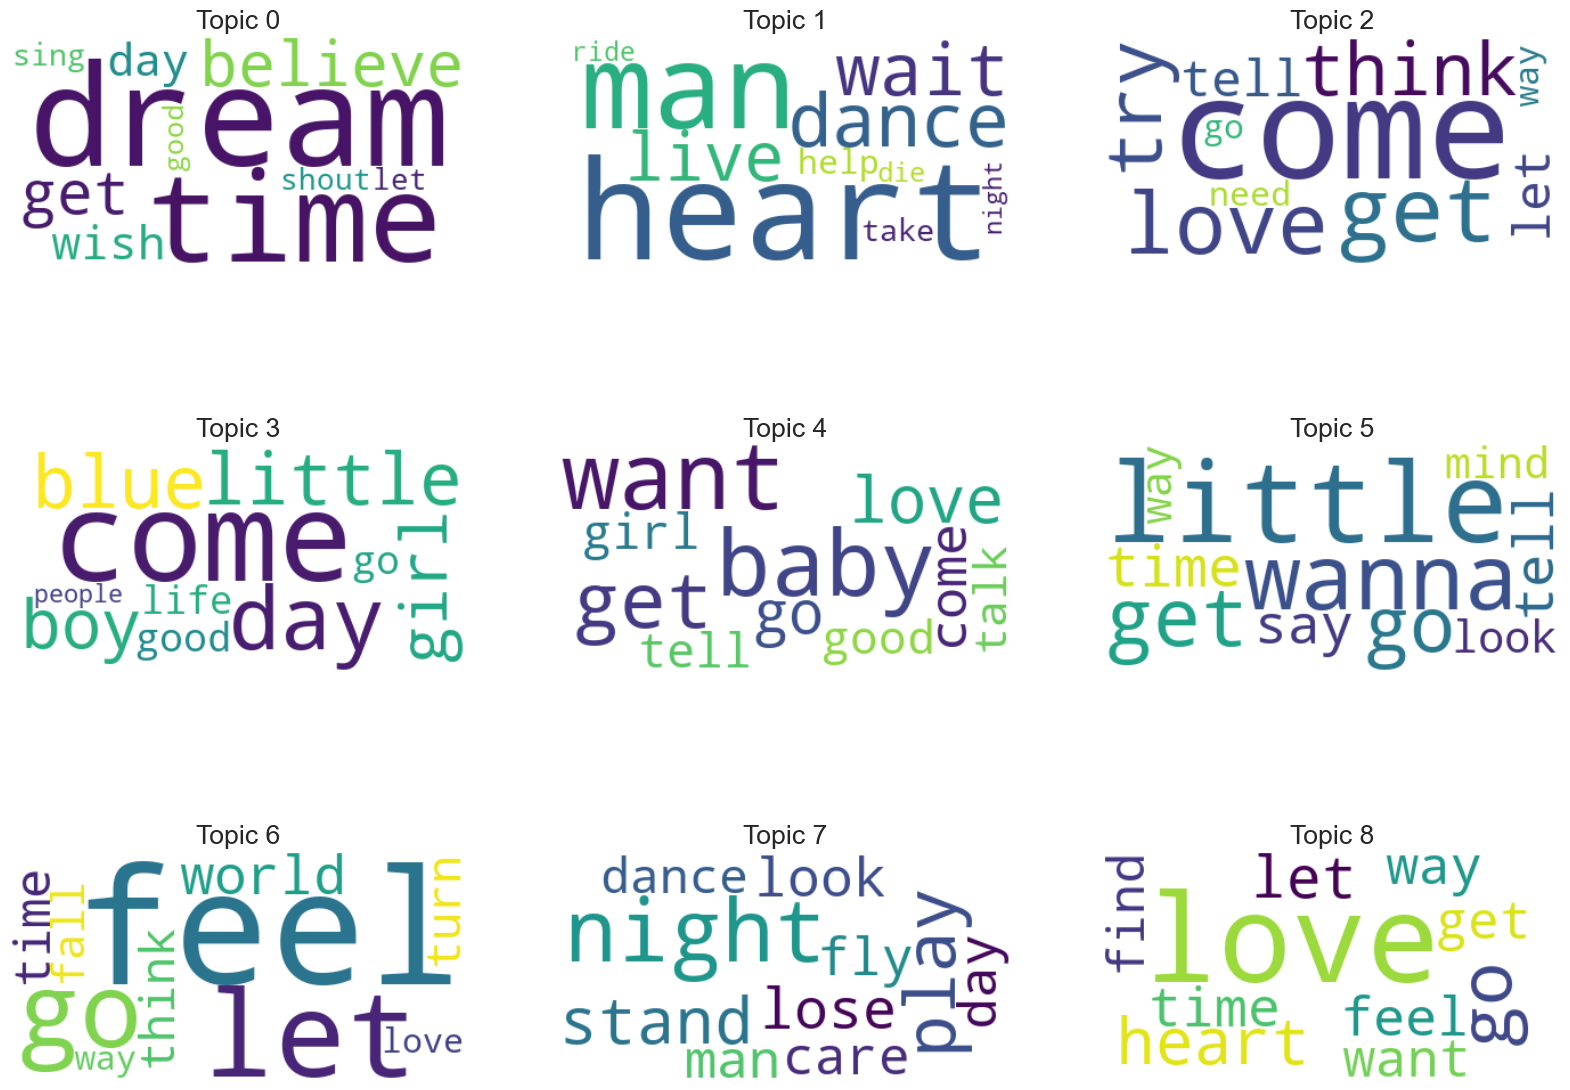

In [85]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

Similar Documents

In [86]:
# Compute and rank consine similarities
lda_index = similarities.MatrixSimilarity(lda_model[bow], num_features=len(dct))

In [87]:
# Returns most similar songs to a given song
def get_similar_songs(song_bow, top_n=5, first_m_words=300):
    similar_songs = lda_index[lda_model[song_bow]]
    top_n_docs = sorted(enumerate(similar_songs), key=lambda item: -item[1])[1:top_n+1]
  
    # Returns (song id, similarity score, first_m_words of song)
    return list(map(lambda entry: (entry[0], entry[1], clean_data[entry[0]][:first_m_words]), top_n_docs))

In [88]:
# Example
print(data[6864][:300],'\n')
get_similar_songs(bow[6864])

IndexError: list index out of range

In [ ]:
#Songs not in corpus
# Pass new song through pipeline
new_song = "Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more"
new_tokens = list(map(custom_tokenizer, [nlp(new_song)]))[0]
new_bow = dct.doc2bow(new_tokens)

print(new_song,'\n')
get_similar_songs(new_bow)

Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more 



[(40043,
  0.9927134,
  "Going back to Alabama.    Going back to Alabama  Now that I've learned the thing too  Life with me ain't been so easy  But I've got some living yet to do.    'Cos a man who walks by the side of the road  Can turn himself around  He can pick himself fast, just himself fast  And start all over again, "),
 (19642,
  0.99182177,
  "The drunken clown's still hanging round  But it plain the laughter's all died down  The tears you tried so hard to hide  Are flowin'  A blind man with his knife in hand  Has convinced himself that he understands  I wish him well, Miss Carousel  But I gotta be a-goin'    Won't you come and get me whe"),
 (50126,
  0.99124324,
  "Hope you didn't burn too many bridges  On your way back to haunt my heart  Cause it's safe behind these stones and ridges  You know how us healin' victims are  I take comfort where I find it  In the neon and the crowds  I guess someone like me designed it  This place where old flames aren't allowed "),
 (49557,
  

In [ ]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def calculate_topic_consistency(lda_model, corpus, top_n=20):
    """
    Calculate topic consistency using Jensen-Shannon distance
    
    Parameters:
    - lda_model: trained Gensim LDA model
    - corpus: document corpus used for training
    - top_n: number of top words to consider
    """
    # Get topic distributions for all documents
    doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]
    
    # Convert to dense vectors
    doc_topic_dist = [[prob for _, prob in sorted(doc)] 
                     for doc in doc_topics]
    
    # Calculate pairwise distances
    distances = []
    for i in range(len(doc_topic_dist)):
        for j in range(i+1, len(doc_topic_dist)):
            dist = jensenshannon(doc_topic_dist[i], doc_topic_dist[j])
            distances.append(dist)
    
    # Average distance (lower = more consistent)
    consistency = 1 - np.mean(distances)
    
    return consistency

# Usage
consistency_score = calculate_topic_consistency(lda_model, corpus=bow)

NameError: name 'corpus' is not defined

In [ ]:
def calculate_topic_diversity(lda_model=bow, top_n=20):
    """
    Calculate topic diversity - ratio of unique words across all topics
    
    Parameters:
    - lda_model: trained Gensim LDA model
    - top_n: number of top words per topic to consider
    
    Returns:
    - diversity score between 0 and 1 (higher = more diverse)
    """
    # Get top words for each topic
    topics = [dict(lda_model.show_topic(topic_id, topn=top_n)) 
             for topic_id in range(lda_model.num_topics)]
    
    # Get unique words across all topics
    unique_words = set(word for topic in topics 
                      for word, _ in topic.items())
    
    # Calculate diversity: unique words / (top_n * num_topics)
    diversity = len(unique_words) / (top_n * lda_model.num_topics)
    
    return diversity

# Usage
diversity_score = calculate_topic_diversity(lda_model=bow, top_n=20)

AttributeError: 'list' object has no attribute 'num_topics'